Use environment tf_gp_env as it has tensorflow 2.10 and CUDA 11.2

In this ML model, we attempt to increase the resolution of satellite precipitation images from IMERG dataset. IMERG dataset provides resolution at 0.1 x 0.1 degrees which is approximately 10km by 10km. We attempt to increase resolution to 2km by 2km by upscaling 5x.

Model architecture. Given an image of size (173,174) we do
1) Slice to (170,170), label this as "high res (hr)"
2) Downscale to coarser resolution (170,170) -> (34,34), label this as "low res (lr)"
3) Run rainFARM algorith and upscale lr back to (170,170), label this as "super resolved (sr)"
4) Train the RDN with sr as input and hr as target. This aims to correct the rainFARM algorithm
5) Take the original (170,170) and upscale using rainFARM to (850,850) and input into the trained model to produce a corrected super resolved upscaled image.

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.10.0


Checking of available GPUs

In [8]:
# List all physical devices
devices = tf.config.list_physical_devices()
print("All physical devices:", devices)

# List all GPUs
gpus = tf.config.list_physical_devices('GPU')
print("All GPUs:", gpus)

# Get detailed GPU information
for gpu in gpus:
    print("GPU details:", gpu)

# Optionally, print which GPU is being used for a specific operation
with tf.device('/GPU:0'):
    a = tf.constant(1.0)
    b = tf.constant(2.0)
    c = a + b
    print("Result:", c)


All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result: tf.Tensor(3.0, shape=(), dtype=float32)


Data initialization and preprocessing

In [9]:
import os
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
from pysteps.downscaling import rainfarm


def preprocess_image(file_path, downscale_factor):
    ds = xr.open_dataset(file_path)
    precip = ds['precipitation'].values[0, :170, :170]
    downscale_size = (precip.shape[0] // downscale_factor, precip.shape[1] // downscale_factor)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=1)
    C = rainfarm.downscale(B, downscale_factor)
    return precip[..., np.newaxis], C[..., np.newaxis]

def load_dataset(folder_path, downscale_factor):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]
    hr_images, lr_images = [], []
    for file_path in files:
        hr_image, lr_image = preprocess_image(file_path, downscale_factor)
        hr_images.append(hr_image)
        lr_images.append(lr_image)
    return np.array(hr_images), np.array(lr_images)

folder_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\ML model'
downscale_factor = 5
hr_data, lr_data = load_dataset(folder_path, downscale_factor)

def create_tf_dataset(hr_data, lr_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((lr_data, hr_data))
    dataset = dataset.cache().shuffle(len(hr_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 16
train_dataset = create_tf_dataset(hr_data, lr_data, batch_size)


Model architecture of Residual Dense Network (simplified)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Residual Dense Block
class ResidualDenseBlock(layers.Layer):
    def __init__(self, filters, growth_rate, **kwargs):
        super(ResidualDenseBlock, self).__init__(**kwargs)
        self.filters = filters
        self.growth_rate = growth_rate
        self.conv1 = layers.Conv2D(growth_rate, 3, padding='same')
        self.conv2 = layers.Conv2D(growth_rate, 3, padding='same')
        self.conv3 = layers.Conv2D(filters, 3, padding='same')
        self.relu = layers.ReLU()
    def get_config(self):
        config = super(ResidualDenseBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'growth_rate': self.growth_rate
        })
        return config
    def call(self, x):
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(tf.concat([x, out1], axis=-1)))
        out3 = self.conv3(tf.concat([x, out1, out2], axis=-1))
        return out3 * 0.2 + x

# Define Residual Dense Network
def build_rdn_model(num_channels=1, num_features=64, growth_rate=32, num_blocks=8):
    inputs = layers.Input(shape=(None, None, num_channels))
    x = layers.Conv2D(num_features, 3, padding='same')(inputs)
    for _ in range(num_blocks):
        x = ResidualDenseBlock(num_features, growth_rate)(x)
    x = layers.Conv2D(num_channels, 3, padding='same')(x)
    model = models.Model(inputs, x)
    return model


Training

In [12]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

# Build and compile the model
generator = build_rdn_model()
generator.compile(optimizer='adam', loss='mse')

# Train the model
generator.fit(train_dataset, epochs=25)

# Save the final model
generator.save('generator_final.h5')


Epoch 1/25
284/284 [==============================] - 144s 502ms/step - loss: 0.8945
Epoch 2/25
284/284 [==============================] - 141s 497ms/step - loss: 0.8498
Epoch 3/25
284/284 [==============================] - 141s 498ms/step - loss: 0.8382
Epoch 4/25
284/284 [==============================] - 141s 495ms/step - loss: 0.8318
Epoch 5/25
284/284 [==============================] - 141s 497ms/step - loss: 0.8233
Epoch 6/25
284/284 [==============================] - 141s 497ms/step - loss: 0.8137
Epoch 7/25
284/284 [==============================] - 140s 493ms/step - loss: 0.8036
Epoch 8/25
284/284 [==============================] - 140s 492ms/step - loss: 0.7910
Epoch 9/25
284/284 [==============================] - 141s 495ms/step - loss: 0.7760
Epoch 10/25
284/284 [==============================] - 141s 497ms/step - loss: 0.7648
Epoch 11/25
284/284 [==============================] - 141s 495ms/step - loss: 0.7594
Epoch 12/25
284/284 [==============================] - 140s 493

Testing and visualisation

1/1 [==============================] - 0s 499ms/step


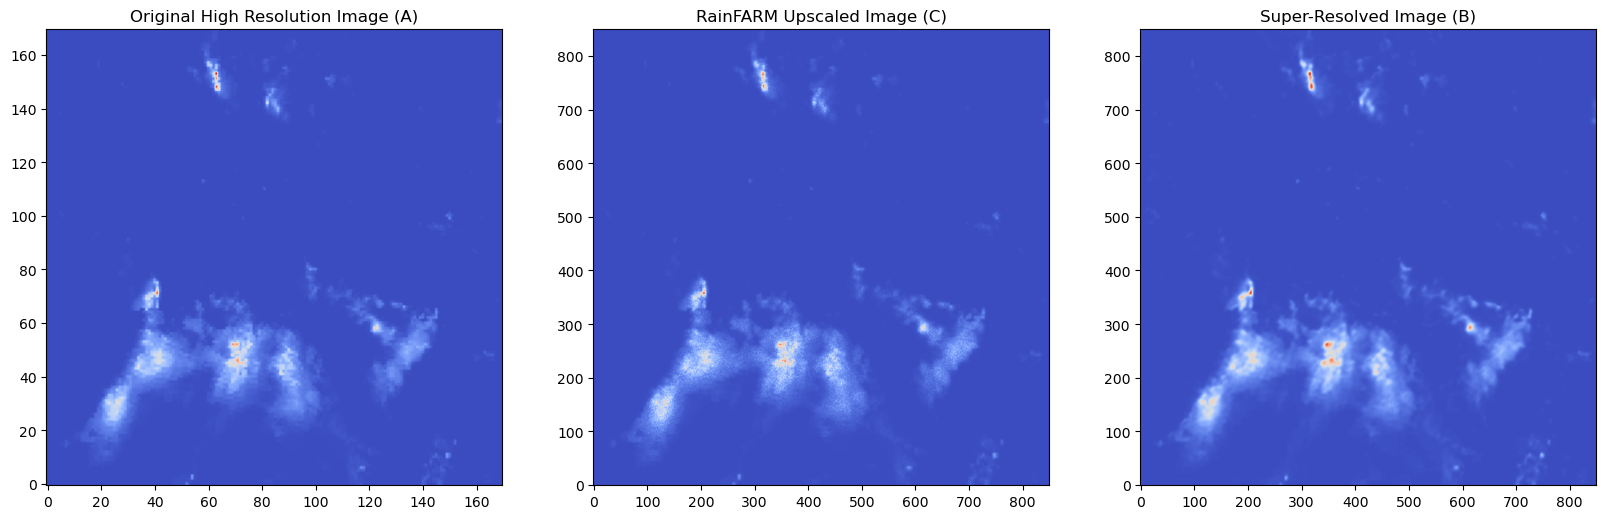

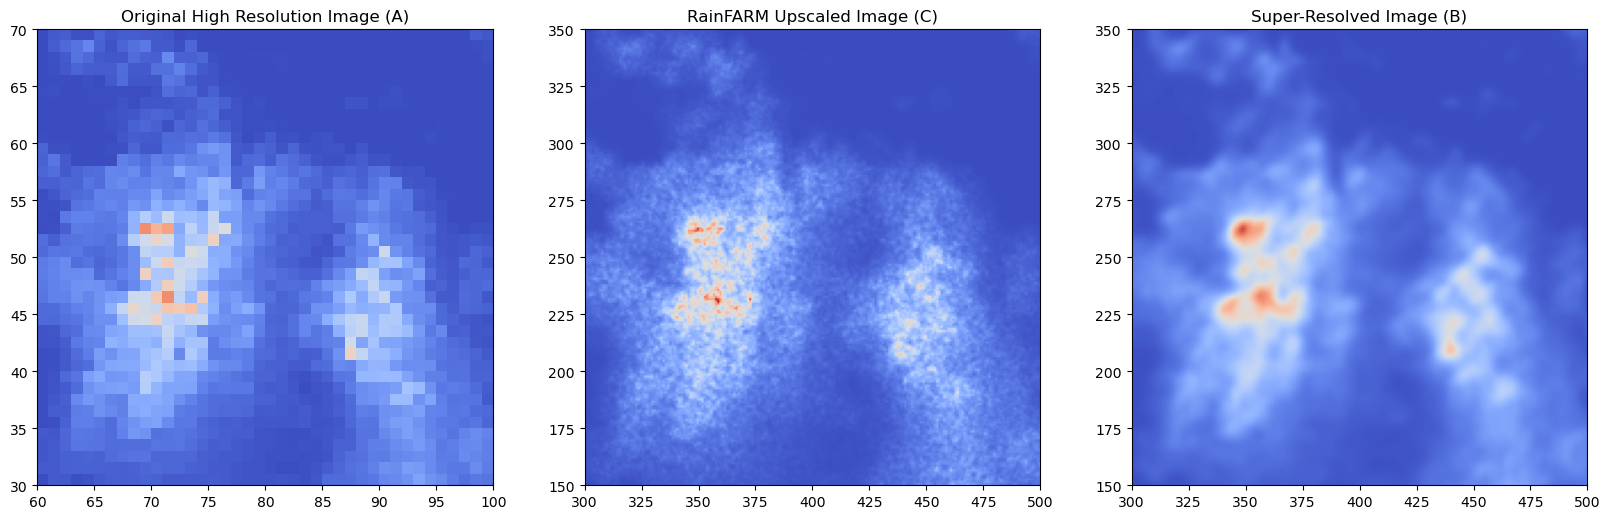

In [17]:
generator = tf.keras.models.load_model('generator_final.h5', custom_objects={'ResidualDenseBlock': ResidualDenseBlock})

new_file_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\ML model\20200831-2230.nc'

def test_image(file_path, downscale_factor):
    ds = xr.open_dataset(file_path)
    precip = ds['precipitation'].values[0, :170, :170]
    downscale_size = (precip.shape[0] // 1, precip.shape[1] // 1)
    B = zoom(precip, (downscale_size[0] / precip.shape[0], downscale_size[1] / precip.shape[1]), order=1)
    C = rainfarm.downscale(B, downscale_factor)
    return precip[..., np.newaxis], C[..., np.newaxis]
hr_image, lr_image = test_image(new_file_path, 5)

sr_image = generator.predict(tf.convert_to_tensor([lr_image]))[0, ..., 0]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 15))
axes[0].imshow(hr_image[..., 0], cmap='coolwarm', origin='lower')
axes[0].set_title('Original High Resolution Image (A)')

axes[1].imshow(lr_image[..., 0], cmap='coolwarm', origin='lower')
axes[1].set_title('RainFARM Upscaled Image (C)')

axes[2].imshow(sr_image, cmap='coolwarm', origin='lower')
axes[2].set_title('Super-Resolved Image (B)')



plt.show()

x_start, x_end, y_start, y_end = 60, 100, 30, 70

fig, axes = plt.subplots(1, 3, figsize=(20, 15))
axes[0].imshow(hr_image[..., 0], cmap='coolwarm', origin='lower',
               extent=(0, hr_image.shape[1], 0, hr_image.shape[0]))
axes[0].set_xlim(x_start, x_end)
axes[0].set_ylim(y_start, y_end)
axes[0].set_title('Original High Resolution Image (A)')

axes[1].imshow(lr_image[..., 0], cmap='coolwarm', origin='lower',
               extent=(0, lr_image.shape[1], 0, lr_image.shape[0]))
axes[1].set_xlim(x_start * 5, x_end * 5)
axes[1].set_ylim(y_start * 5, y_end * 5)
axes[1].set_title('RainFARM Upscaled Image (C)')

axes[2].imshow(sr_image, cmap='coolwarm', origin='lower',
               extent=(0, sr_image.shape[1], 0, sr_image.shape[0]))
axes[2].set_xlim(x_start * 5, x_end * 5)
axes[2].set_ylim(y_start * 5, y_end * 5)
axes[2].set_title('Super-Resolved Image (B)')



plt.show()
